# Classification of synthetic time series data
Following on from simulating data using SSA, we aim to classify the time series generated with an ML algorithm e.g, Support Vector Machine (SVM), and they need to be similar enough to be difficult to classify.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import os
# import tqdm
# from sympy import sqrt
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# from sklearn.decomposition import PCA
# Import all the functions from the 'src' directory, we import all the functions from each module so we can use them straight away
# from simulation.simulate_telegraph_model import simulate_two_telegraph_model_systems
from stats.report import *
from visualisation.plots import *
from stats.autocorrelation import *
# from classifiers.logistic_regression_classifier import logistic_regression_classifier
# from classifiers.svm_classifier import svm_classifier
# from classifiers.random_forest_classifier import random_forest_classifier
# from classifiers.mlp_classifier import mlp_classifier
# from classifiers.lstm_classifier import lstm_classifier
# from classifiers.random_classifier import random_classifier
# from utils.load_data import load_and_split_data
# from models.mlp import MLP
from statsmodels.nonparametric.smoothers_lowess import lowess
%load_ext autoreload
%autoreload 2

## Change the variance ratio over a range, then plot Variance Ratio VS. Prediction Accuracy (SVM, Random Forest, Logistic Regression and Random Classifier)

<span style="color: red">**This will run for a while, so I ran this in a separate python script instead. The script and the data is stored in **var_v_accuracy_plot.py**</span>

<span style='color:red'>**DON'T RUN THIS IN THE NOTEBOOK.**</span>

In [ ]:
# Define system parameters
variance_target_normal = 1200.0
variance_ratios = np.arange(0.1, 3.0, 0.01)

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition
d_stress = d_normal = 1 # Define degradation rates

'''
# Iterate over different variance ratios
for ratio in tqdm.tqdm(variance_ratios, desc="Running Variance Ratio Simulations"):
    variance_target_stress = ratio * variance_target_normal  # Adjust stress variance based on ratio

    # Compute transcription rates (rho) for both conditions
    rho_stress = - (sigma_b_stress + sigma_u_stress) * np.sqrt(d_stress + sigma_b_stress + sigma_u_stress) * (
        np.sqrt(sigma_b_stress) * np.sqrt(d_stress + sigma_b_stress + sigma_u_stress) -
        np.sqrt(sigma_b_stress * (sigma_b_stress + sigma_u_stress) + d_stress * (sigma_b_stress + 4 * variance_target_stress * sigma_u_stress))
    ) / (2 * np.sqrt(sigma_b_stress) * sigma_u_stress)

    rho_normal = - (sigma_b_normal + sigma_u_normal) * np.sqrt(d_normal + sigma_b_normal + sigma_u_normal) * (
        np.sqrt(sigma_b_normal) * np.sqrt(d_normal + sigma_b_normal + sigma_u_normal) -
        np.sqrt(sigma_b_normal * (sigma_b_normal + sigma_u_normal) + d_normal * (sigma_b_normal + 4 * variance_target_normal * sigma_u_normal))
    ) / (2 * np.sqrt(sigma_b_normal) * sigma_u_normal)

    # Update parameter sets
    parameter_sets = [
        {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
        {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
    ]

    # Set simulation parameters
    time_points = np.arange(0, 144.0, 1.0)  
    size = 200  
    # set the number of iterations to run for the simulation
    num_iterations = 10

    for i in range(num_iterations):
        # Run the simulation
        df_results = simulate_two_telegraph_model_systems(parameter_sets, time_points, size)

        # Save dataset for ML classification
        output_dir = f"data/mRNA_trajectories_variance_{int(variance_target_stress)}_{int(variance_target_normal)}"
        os.makedirs(output_dir, exist_ok=True)

        output_file = f"{output_dir}/m_traj_{variance_target_stress}_{variance_target_normal}_{i}.csv"
        df_results.to_csv(output_file, index=False)

        # Extract mRNA trajectories
        stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  
        normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  

        # Statistical report
        stats = statistical_report(parameter_sets, stress_trajectories, normal_trajectories)

        # classifiers
        X_train, X_test, y_train, y_test = load_and_split_data(output_file)
        svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
        rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
        log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
        random_accuracy = random_classifier(y_test)
        df_acc_results = pd.DataFrame({
            "Parameter Sets": parameter_sets,
            "Stats": stats,
            "Variance Ratio": ratio,
            "SVM Accuracy": svm_accuracy,
            "Random Forest Accuracy": rf_accuracy,
            "Logistic Regression Accuracy": log_reg_accuracy,
            "Random Classifier Accuracy": random_accuracy
        })

        # Save the accuracy results to a csv file
        if not os.path.isfile("data/accuracy_results.csv"):
            df_acc_results.to_csv("data/accuracy_results.csv", index=False)
        else:
            df_acc_results.to_csv("data/accuracy_results.csv", mode='a', header=False, index=False)
'''

The result

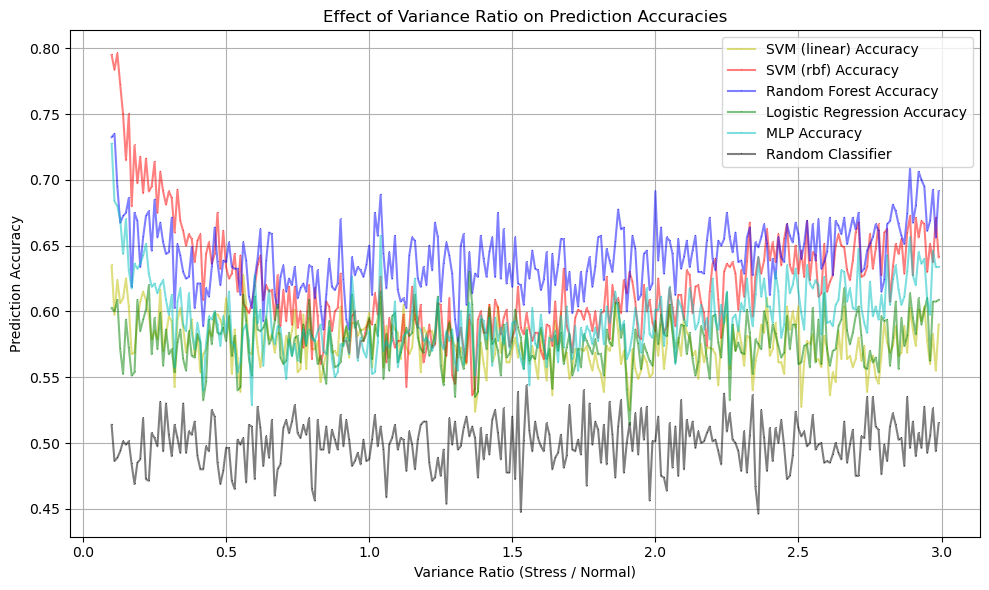

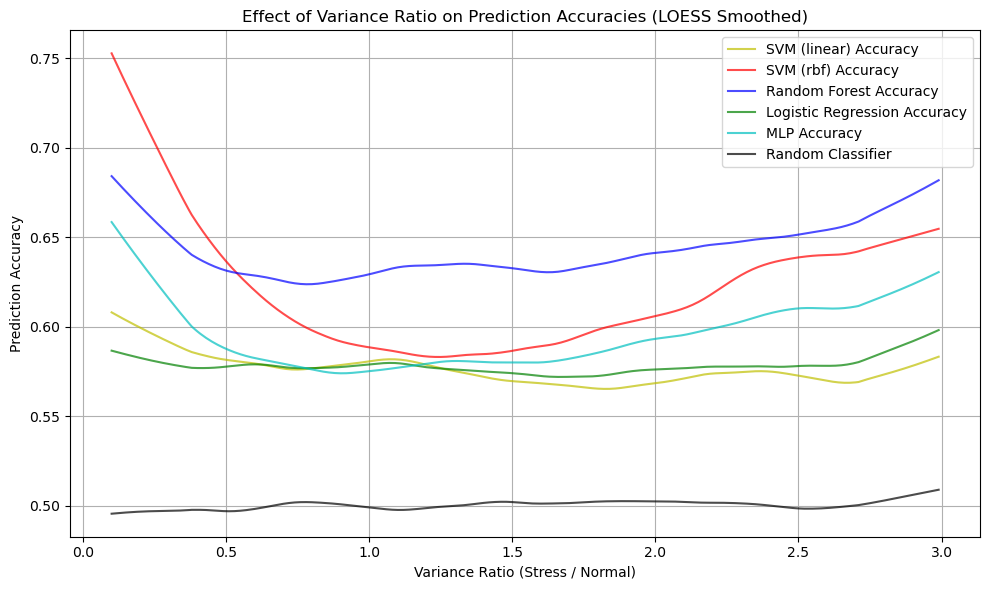

In [2]:
# Read in accuracy data
df_acc_results = pd.read_csv("data/accuracy_results_05_03_2025.csv")
# Extract the variance ratios and accuracies
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()


plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs SVM Accuracy
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha= 0.5)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)

# Plot the LOESS smoothed data
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess.png")
plt.show()

Benchmarking: keeping the mean constant whilst changing the variance

In [ ]:
# Read in accuracy data
df_acc_results = pd.read_csv("data/accuracy_results_26_03_2025.csv")
df_acc_results.head()

,Parameter Sets,Stats,Variance Ratio,SVM (rbf) Accuracy,SVM (linear) Accuracy,Random Forest Accuracy,Logistic Regression Accuracy,MLP Accuracy,Random Classifier Accuracy
0,"[{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...","({'Stressed Mean': 9.795746268656716, 'Stresse...",0.1,1.0,0.650,1.0,0.6625,0.9500,0.45
1,"[{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...","({'Stressed Mean': 10.174776119402985, 'Stress...",0.1,1.0,0.725,1.0,0.7000,0.9375,0.45
2,"[{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...","({'Stressed Mean': 10.174776119402985, 'Stress...",0.1,1.0,0.725,1.0,0.7000,0.9375,0.45
3,"[{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...","({'Stressed Mean': 10.174776119402985, 'Stress...",0.1,1.0,0.725,1.0,0.7000,0.9375,0.45
4,"[{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...","({'Stressed Mean': 10.174776119402985, 'Stress...",0.1,1.0,0.725,1.0,0.7000,0.9375,0.45


In [4]:
df_lstm_acc_results = pd.read_csv('data/accuracy_results_04_04_2025.csv')
df_lstm_acc_results.head()

,Parameter Sets,Stats,Variance Ratio,LSTM Accuracy
0,"[{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...","({'Stressed Mean': 9.795746268656716, 'Stresse...",0.1,0.5250
1,"[{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...","({'Stressed Mean': 10.174776119402985, 'Stress...",0.1,0.9875
2,"[{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...","({'Stressed Mean': 10.174776119402985, 'Stress...",0.1,0.9875
3,"[{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...","({'Stressed Mean': 10.174776119402985, 'Stress...",0.1,0.9875
4,"[{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...","({'Stressed Mean': 10.174776119402985, 'Stress...",0.1,0.9875


In [5]:
# Extract the variance ratios and accuracies
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()
lstm_accuracy = df_lstm_acc_results.groupby("Variance Ratio")["LSTM Accuracy"].mean()

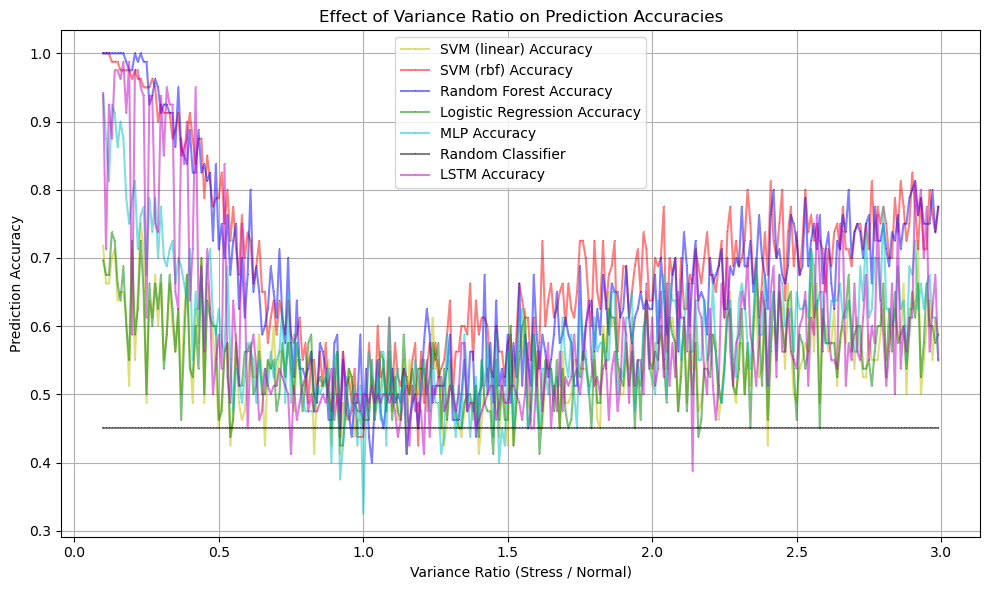

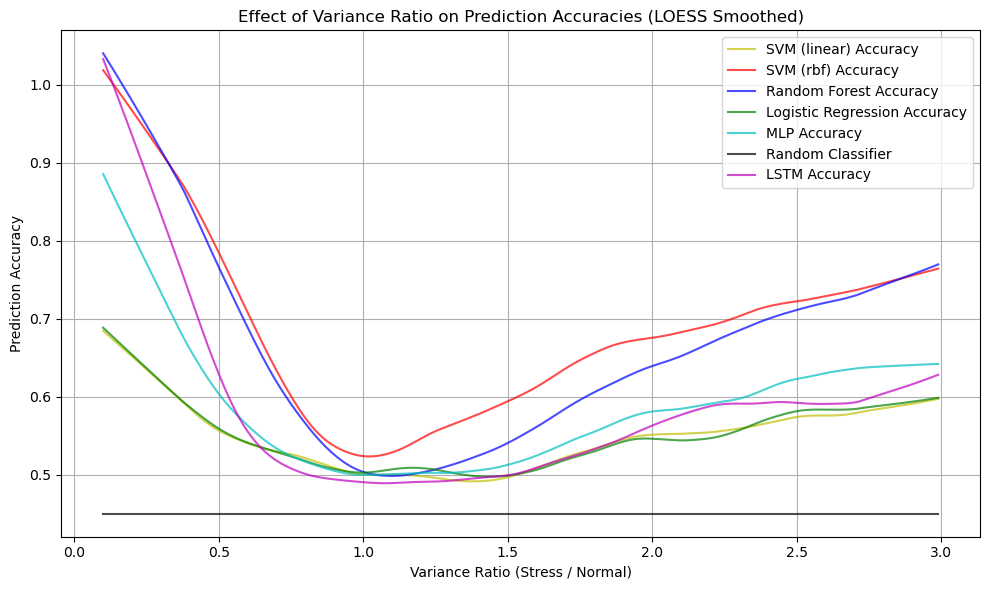

In [6]:
plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs SVM Accuracy
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha= 0.5)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.plot(variance_ratios_recorded, lstm_accuracy, marker=',', linestyle='-', color='m', label="LSTM Accuracy", alpha=0.5)
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)
lstm_loess = lowess(lstm_accuracy, variance_ratios_recorded, frac=0.2)

# Plot the LOESS smoothed data
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.plot(lstm_loess[:, 0], lstm_loess[:, 1], linestyle='-', color='m', alpha=0.7, label="LSTM Accuracy")
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess.png")
plt.show()

## Benchmarking: keeping the mean and autocorr constant whilst changing variance

In [2]:
# Read in accuracy data
df_acc_results = pd.read_csv("data/accuracy_results_03_04_2025.csv")
df_acc_results.head()

,Parameter Sets,Stats,Variance Ratio,SVM (rbf) Accuracy,SVM (linear) Accuracy,Random Forest Accuracy,Logistic Regression Accuracy,MLP Accuracy,Random Classifier Accuracy
0,"[{'sigma_u': 18.0, 'sigma_b': 0.61731419342937...","({'Stressed Mean': 10.141908396946565, 'Stress...",0.1,1.0000,0.6625,1.0,0.675,0.9375,0.45
1,"[{'sigma_u': 18.0, 'sigma_b': 0.61731419342937...","({'Stressed Mean': 9.982366412213741, 'Stresse...",0.1,0.9875,0.7750,1.0,0.775,0.8875,0.45
2,"[{'sigma_u': 18.0, 'sigma_b': 0.61731419342937...","({'Stressed Mean': 9.982366412213741, 'Stresse...",0.1,0.9875,0.7750,1.0,0.775,0.8875,0.45
3,"[{'sigma_u': 18.0, 'sigma_b': 0.61731419342937...","({'Stressed Mean': 9.982366412213741, 'Stresse...",0.1,0.9875,0.7750,1.0,0.775,0.8875,0.45
4,"[{'sigma_u': 18.0, 'sigma_b': 0.61731419342937...","({'Stressed Mean': 9.982366412213741, 'Stresse...",0.1,0.9875,0.7750,1.0,0.775,0.8875,0.45


In [3]:
df_lstm_acc_results = pd.read_csv("data/accuracy_results_06_04_2025.csv")
df_lstm_acc_results.head()

,Parameter Sets,Stats,Variance Ratio,LSTM Accuracy
0,"[{'sigma_u': 18.0, 'sigma_b': 0.61731419341922...","({'Stressed Mean': 10.141908396946565, 'Stress...",0.1,0.9750
1,"[{'sigma_u': 18.0, 'sigma_b': 0.61731419341922...","({'Stressed Mean': 9.982366412213741, 'Stresse...",0.1,0.9875
2,"[{'sigma_u': 18.0, 'sigma_b': 0.61731419341922...","({'Stressed Mean': 9.982366412213741, 'Stresse...",0.1,0.9875
3,"[{'sigma_u': 18.0, 'sigma_b': 0.61731419341922...","({'Stressed Mean': 9.982366412213741, 'Stresse...",0.1,0.9875
4,"[{'sigma_u': 18.0, 'sigma_b': 0.61731419341922...","({'Stressed Mean': 9.982366412213741, 'Stresse...",0.1,0.9875


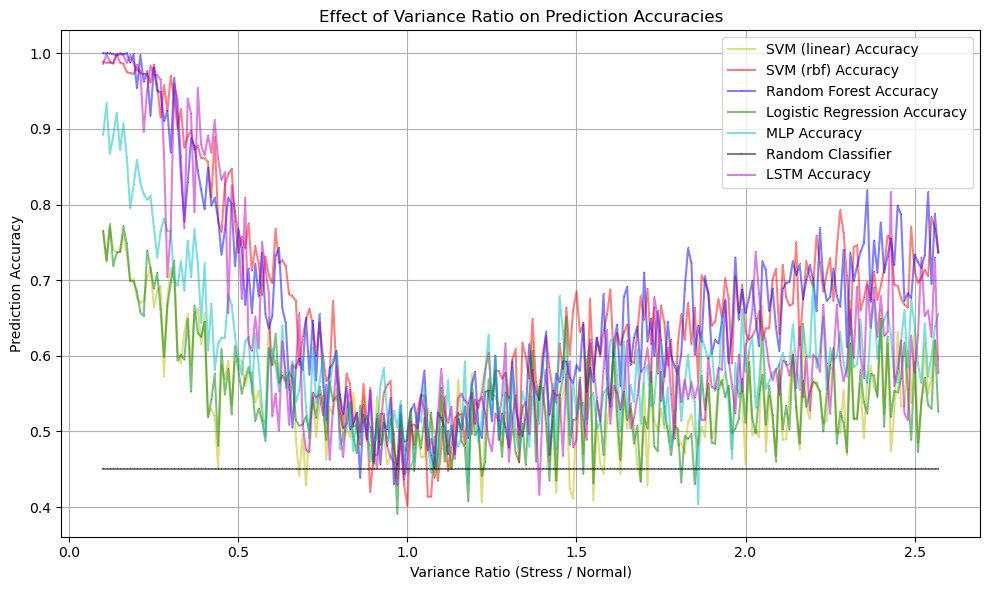

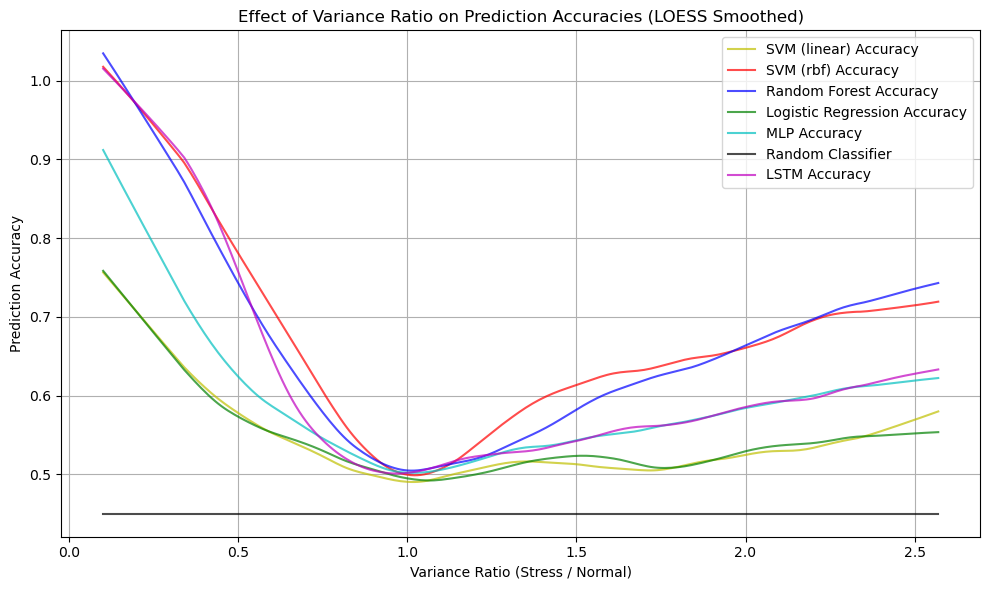

In [6]:
# Extract the variance ratios and accuracies
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()
lstm_accuracy = df_lstm_acc_results.groupby("Variance Ratio")["LSTM Accuracy"].mean()

plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs Classifier Accuracy
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha= 0.5)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.plot(variance_ratios_recorded, lstm_accuracy, marker=',', linestyle='-', color='m', label="LSTM Accuracy", alpha=0.5)
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)
lstm_loess = lowess(lstm_accuracy, variance_ratios_recorded, frac=0.2)

# Plot the LOESS smoothed data
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.plot(lstm_loess[:, 0], lstm_loess[:, 1], linestyle='-', color='m', alpha=0.7, label="LSTM Accuracy")
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess.png")
plt.show()

## Finetuned LSTM Model Benchmark
!! An accidental mistake was made for the LSTM classifier, where ``use_conv1d`` and ``use_attention`` were set to ``True``, AND, ``num_attention_heads`` was set to `4` but this somehow made it a better classifer than the LSTM Conv1D classifier, the parameters used for LSTM classifier:

```
def lstm_classifier(X_train, X_val, X_test, y_train, y_val, y_test, 
                    input_size=None, hidden_size=64, num_layers=2, 
                    output_size=None, dropout_rate=0.3, learning_rate=0.001, 
                    batch_size=64, epochs=50, patience=10, bidirectional=True, use_attention=True, use_conv1d=True): 
```

Parameters used for the LSTM Conv1D classifier:

```
def lstm_conv1d_classifier(X_train, X_val, X_test, y_train, y_val, y_test, 
                    input_size=None, hidden_size=64, num_layers=2, 
                    output_size=None, dropout_rate=0.01, learning_rate=0.001, 
                    batch_size=32, epochs=50, patience=10, bidirectional=True, use_attention=False, use_conv1d=True):
```


In [ ]:
################## Rectify the LSTM Accuracy column name ##################
# df_acc_results = pd.read_csv("data/accuracy_results_12_04_2025.csv")
# df_acc_results = pd.read_csv("data/accuracy_results_11_04_2025.csv")
# change the LSTM Accuracy column to LSTM Conv1D Attnention Accuracy
# df_acc_results.rename(columns={'LSTM Accuracy': 'LSTM Conv1D 4-Head Attention Accuracy'}, inplace=True)
# save the dataframe to a csv file
# df_acc_results.to_csv("data/accuracy_results_11_04_2025.csv", index=False)

################# Rectify the LSTM Accuracy column name ##################

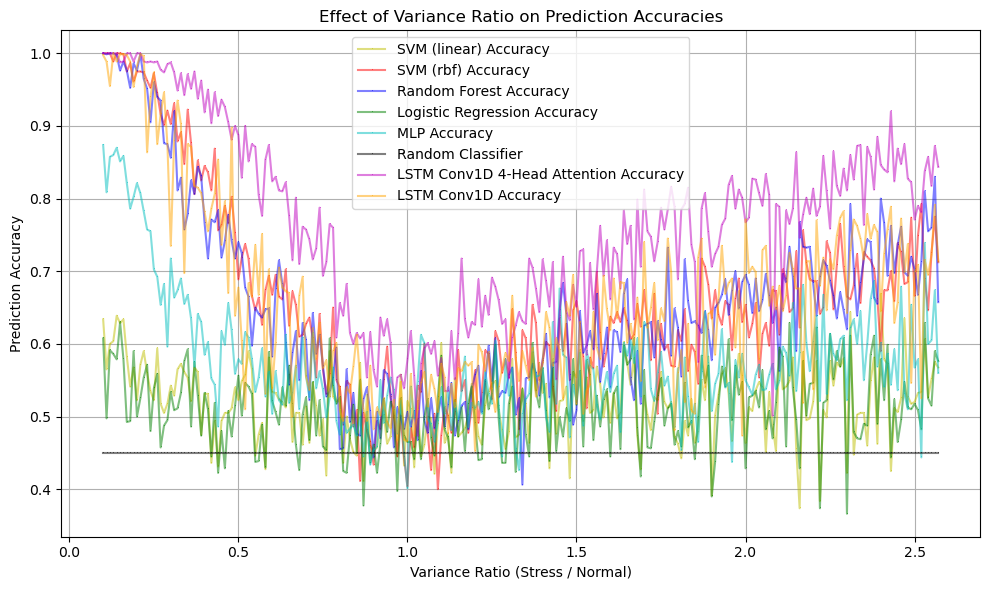

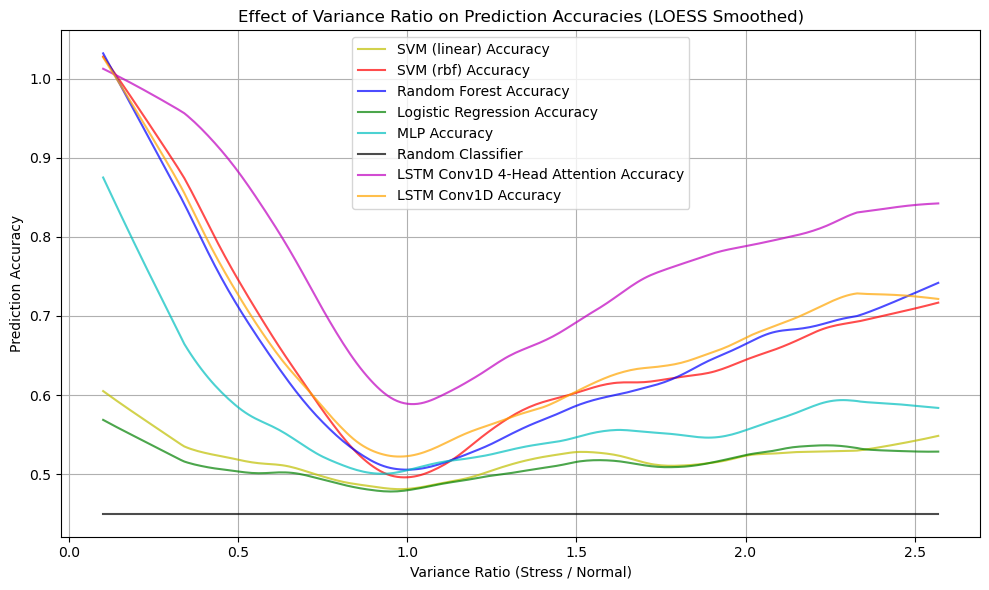

In [7]:
# Read in accuracy data
# df_acc_results = pd.read_csv("data/accuracy_results_12_04_2025.csv")
df_acc_results = pd.read_csv("data/accuracy_results_11_04_2025.csv")
# Extract the variance ratios and accuracies
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()
lstm_accuracy_conv1d_4_attention_accuracy = df_acc_results.groupby("Variance Ratio")["LSTM Conv1D 4-Head Attention Accuracy"].mean()
lstm_conv1d_accuracy = df_acc_results.groupby("Variance Ratio")["LSTM Conv1D Accuracy"].mean()
##### plotting
plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs SVM Accuracy
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha= 0.5)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.plot(variance_ratios_recorded, lstm_accuracy_conv1d_4_attention_accuracy, marker=',', linestyle='-', color='m', label="LSTM Conv1D 4-Head Attention Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, lstm_conv1d_accuracy, marker=',', linestyle='-', color='orange', label="LSTM Conv1D Accuracy", alpha=0.5)
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)
lstm_conv1d_4_attention_loess = lowess(lstm_accuracy_conv1d_4_attention_accuracy, variance_ratios_recorded, frac=0.2)
lstm_conv1d_loess = lowess(lstm_conv1d_accuracy, variance_ratios_recorded, frac=0.2)

# Plot the LOESS smoothed data
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.plot(lstm_conv1d_4_attention_loess[:, 0], lstm_conv1d_4_attention_loess[:, 1], linestyle='-', color='m', alpha=0.7, label="LSTM Conv1D 4-Head Attention Accuracy")
plt.plot(lstm_conv1d_loess[:, 0], lstm_conv1d_loess[:, 1], linestyle='-', color='orange', alpha=0.7, label="LSTM Conv1D Accuracy")
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess.png")
plt.show()

## Benchmark (Pre-Trained) IY002A LSTM Model Against Others

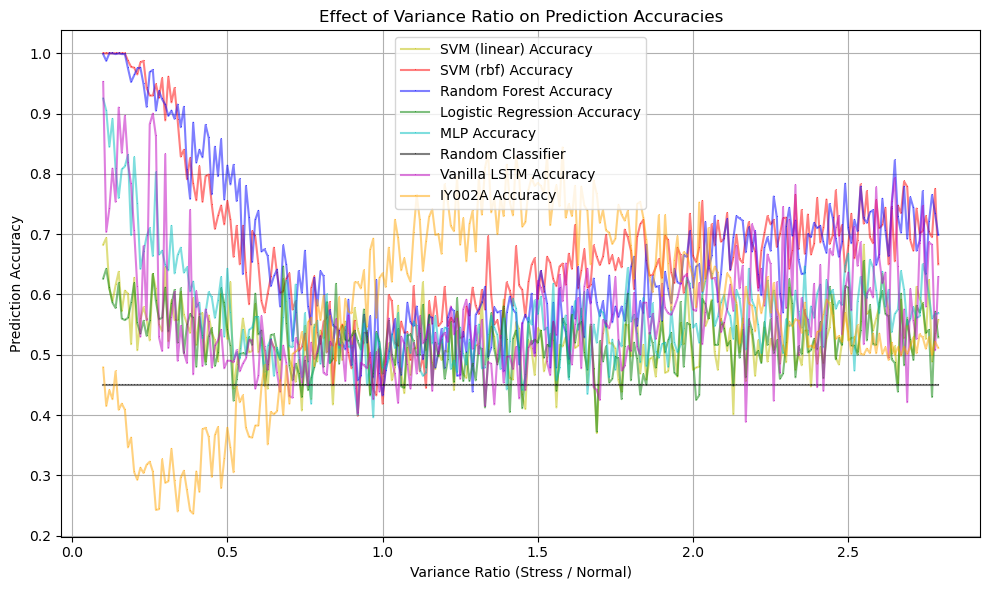

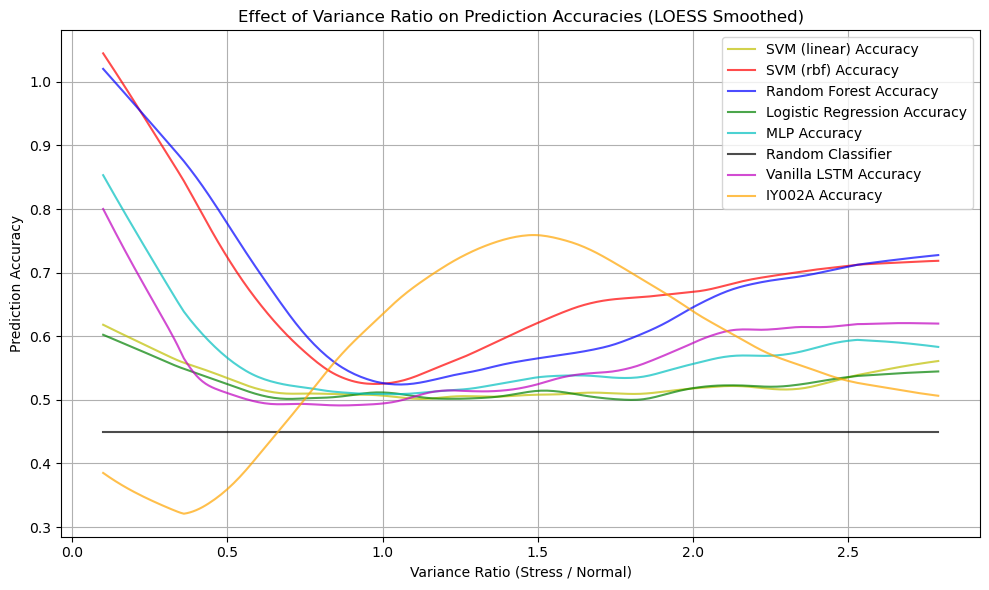

In [4]:
# Read in accuracy data
df_acc_results = pd.read_csv("/home/ianyang/stochastic_simulations/experiments/SSA_telegraph_model/EXP-25-IY002/data/IY002A.csv")
# Extract the variance ratios and accuracies
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()
lstm_accuracy = df_acc_results.groupby("Variance Ratio")["Vanilla LSTM Accuracy"].mean()
iy002a_accuracy = df_acc_results.groupby("Variance Ratio")["IY002A Accuracy"].mean()
##### plotting
plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs Classifier Accuracies
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha= 0.5)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.plot(variance_ratios_recorded, lstm_accuracy, marker=',', linestyle='-', color='m', label="Vanilla LSTM Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, iy002a_accuracy, marker=',', linestyle='-', color='orange', label="IY002A Accuracy", alpha=0.5)

plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)
lstm_loess = lowess(lstm_accuracy, variance_ratios_recorded, frac=0.2)
iy002a_loess = lowess(iy002a_accuracy, variance_ratios_recorded, frac=0.2)

# Plot the LOESS smoothed data
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.plot(lstm_loess[:, 0], lstm_loess[:, 1], linestyle='-', color='m', alpha=0.7, label="Vanilla LSTM Accuracy")
plt.plot(iy002a_loess[:, 0], iy002a_loess[:, 1], linestyle='-', color='orange', alpha=0.7, label="IY002A Accuracy")
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess.png")
plt.show()

## Benchmark IY001A LSTM Model

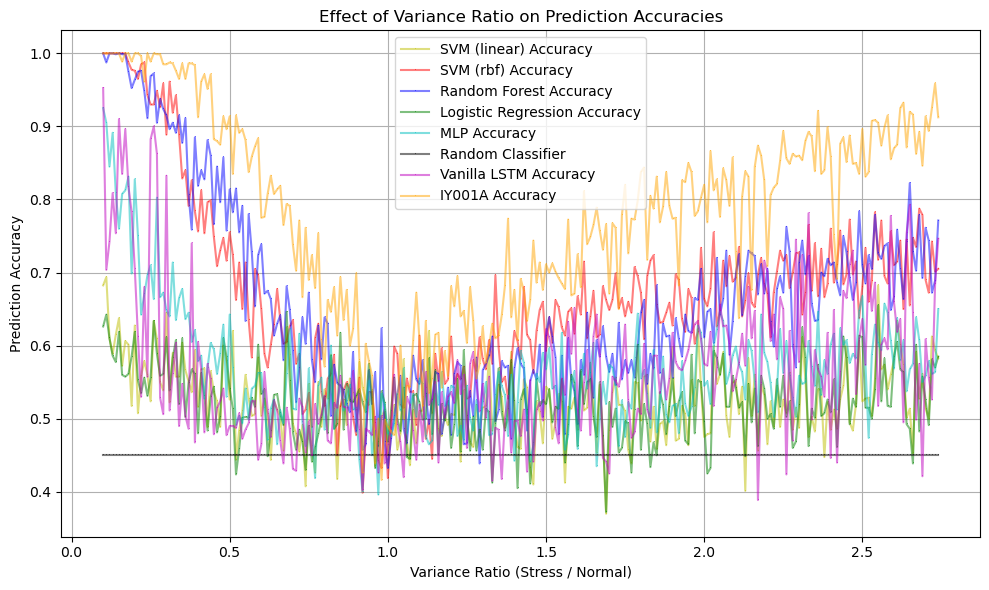

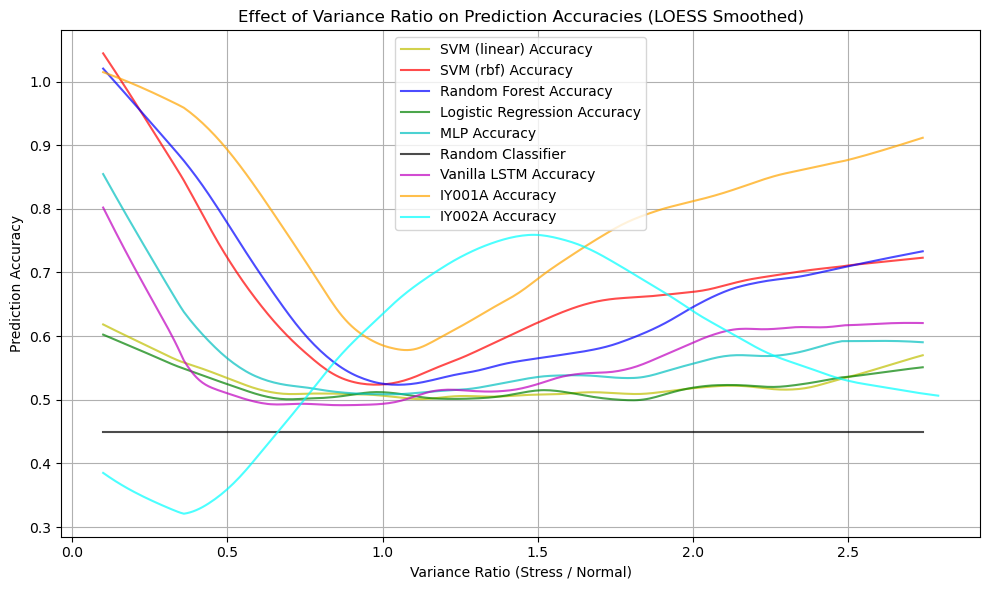

In [5]:
# Read in accuracy data
df_acc_results = pd.read_csv("/home/ianyang/stochastic_simulations/experiments/SSA_telegraph_model/EXP-25-IY004/data/IY004A.csv")
# Extract the variance ratios and accuracies
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()
lstm_accuracy = df_acc_results.groupby("Variance Ratio")["Vanilla LSTM Accuracy"].mean()
iy001a_accuracy = df_acc_results.groupby("Variance Ratio")["IY001A Accuracy"].mean()
##### plotting
plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs Classifier Accuracies
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha= 0.5)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.plot(variance_ratios_recorded, lstm_accuracy, marker=',', linestyle='-', color='m', label="Vanilla LSTM Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, iy001a_accuracy, marker=',', linestyle='-', color='orange', label="IY001A Accuracy", alpha=0.5)

plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)
lstm_loess = lowess(lstm_accuracy, variance_ratios_recorded, frac=0.2)
iy001a_loess = lowess(iy001a_accuracy, variance_ratios_recorded, frac=0.2)

# Plot the LOESS smoothed data
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.plot(lstm_loess[:, 0], lstm_loess[:, 1], linestyle='-', color='m', alpha=0.7, label="Vanilla LSTM Accuracy")
plt.plot(iy001a_loess[:, 0], iy001a_loess[:, 1], linestyle='-', color='orange', alpha=0.7, label="IY001A Accuracy")
plt.plot(iy002a_loess[:, 0], iy002a_loess[:, 1], linestyle='-', color='cyan',alpha=0.7, label="IY002A Accuracy")
# plt.plot(lstm_conv1d_4_attention_loess[:, 0], lstm_conv1d_4_attention_loess[:, 1], linestyle='-', color='m', alpha=0.7, label="LSTM Conv1D 4-Head Attention Accuracy")

plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess.png")
plt.show()